In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Datenvorverarbeitung mit Pandas: Food Nutrient Database

Diese Aufgabe befasst sich mit einer deutlich umfangreicheren Datenbank des U.S. Department of Agriculture, aufbereitet im Format JSON von A. Williams, zum Thema Nährstoffge- halt von Nahrungsmitteln. Sie enthält 6636 Einträge für Nahrungsmittel, alle in Form von JSON-Records, wie z.B.:
```
{
    "id": 21441,
    "description": "KENTUCKY FRIED CHICKEN, Fried Chicken, EXTRA CRISPY, Wing,
        meat and skin with breading", "tags": ["KFC"],
    "manufacturer": "Kentucky Fried Chicken", "group": "Fast Foods",
    "portions": [ 
        {
            "amount": 1,
            "unit": "wing , with skin",
            "grams": 68.0 
        },
        ...
    ], 
    "nutrients": [
        {
            "value": 20.8,
            "units": "g", 
            "description": "Protein",
            "group": "Composition" 
        },
        ... 
    ]
}
```
Ziel der Analyse in dieser Übung ist es, eine explorative Analyse des Gehalts des Spurenelementes Zink in den verschiedenen Nahrungsmitteln zu durchzuführen. Notwendig dafür sind etwas aufwändigere, aber für die Datenanlyse typische Manipulationen mit Pandas sowie der Einsatz zusätzlicher Python-Standardbibliotheken zum Download und der Verarbeitung von Zip- und JSON-Dateien.

### a)
Laden Sie die Datenbank als zip-File aus Moodle herunter und lesen Sie dieses File direkt in ein neues Notebook ein. Die bisher verwendete Pandas-Methode read_csv() funktioniert für JSON-Files leider nicht. Das heruntergeladene File wird stattdessen mithilfe des Py- thonmoduls zipfile entpackt und dem Python-Befehl open() eingelesen. Die Umwandlung des JSON-Formates in ein geeignetes Python-Format erfolgt mit einem weiteren Modul der Python-Standardlibrary, json, hier mithilfe der Funktion json.load(). Lesen Sie dazu die zugehörigen, auf dem Web bzw. Stackoverflow verfügbaren Anleitungen.

In [2]:
import zipfile
import json

archive = zipfile.ZipFile("data/foods-2011-10-03.json.zip", "r")

with archive.open("foods-2011-10-03.json", "r") as f:
    nutrients_json = json.load(f)

### b)
Die Datenbank steht nun in Form einer Liste aus 6636 Python-Dictionaries zu Verfügung. Jedes Dictionary enthält Angaben zu einem Nahrungsmittel. Greifen Sie sich ein beliebiges Nahrungsmittel heraus und lassen sich die Namen der Einträge mit der Methode dict.keys() anzeigen. Einer der Einträge enthält die enthaltenen Nährstoffe (nutrients), ebenfalls als Dictionary. Lassen Sie sich wiederum einen beliebigen Eintrag der Nährstoffliste anzeigen. Es sollte auffallen, dass manche Feldnamen doppelt vorkommen.

In [3]:
nutrients_json[4].keys()

dict_keys(['id', 'description', 'tags', 'manufacturer', 'group', 'portions', 'nutrients'])

In [5]:
nutrients_json[4]["nutrients"][0].keys()

dict_keys(['value', 'units', 'description', 'group'])

Teile dieser hierarchischen Struktur sollen nun in eine einheitliche Tabelle umgewandelt werden, um eine explorative Analyse durchführen zu können.

Vorgehensweise:

    Kopieren Sie zunächst die Felder description,group,id,manufacturer in einen eigenen DataFrame info, sowie alle Nährstofflisten in ein Array von DataFrames, wobei Sie an jeden DataFrame die entsprechende ID des Nahrungsmittels als eigene Spalte anhängen.
    Dieses Array wird mithilfe der Funktion pandas.concat() zu einem großen DataFrame nutrients (389355 Einträge) vereinigt.
    Entfernen Sie alle Duplikate aus diesem DataFrame.
    Bevor beide DataFrames vereinigt werden können, gibt es noch ein Problem: beide enthalten Felder mit dem Namen description und group (s.o.). Benennen Sie diese daher mithilfe von DataFrame.rename() in eindeutige Namen um.
    Vereinigen Sie beide DataFrames mit pandas.merge(nutrients, info, on=’id’, how=’outer’) anhand der Nahrungsmittel-ID.

Überprüfen Sie das Ergebnis jeder Manipulation mit `DataFrame.head()``.

In [4]:
info = pd.DataFrame(nutrients_json)

info.drop(columns=["tags", "portions", "nutrients"], inplace=True)

In [7]:
info.head()

,id,description,manufacturer,group
0,1008,"Cheese, caraway",,Dairy and Egg Products
1,1009,"Cheese, cheddar",,Dairy and Egg Products
2,1018,"Cheese, edam",,Dairy and Egg Products
3,1019,"Cheese, feta",,Dairy and Egg Products
4,1028,"Cheese, mozzarella, part skim milk",,Dairy and Egg Products


In [8]:
nutrients = []

for row in nutrients_json:
    nutrients.append(pd.DataFrame(row["nutrients"]))
    nutrients[-1]["id"] = row["id"]

nutrients = pd.concat(nutrients)
nutrients.drop_duplicates(inplace=True)

nutrients.rename(columns={"description": "nutrient_description", "group": "nutrient_group"}, inplace=True)
info.rename(columns={"description": "food_description", "group": "food_group"}, inplace=True)

foods = pd.merge(nutrients, info, on="id", how="outer")

In [9]:
foods.head()

,value,units,nutrient_description,nutrient_group,id,food_description,manufacturer,food_group
0,25.18,g,Protein,Composition,1008,"Cheese, caraway",,Dairy and Egg Products
1,29.20,g,Total lipid (fat),Composition,1008,"Cheese, caraway",,Dairy and Egg Products
2,3.06,g,"Carbohydrate, by difference",Composition,1008,"Cheese, caraway",,Dairy and Egg Products
3,3.28,g,Ash,Other,1008,"Cheese, caraway",,Dairy and Egg Products
4,376.00,kcal,Energy,Energy,1008,"Cheese, caraway",,Dairy and Egg Products


In [10]:
foods.shape

(375176, 8)

### c)
Nun sind die Daten bereit für die Untersuchung auf das Spurenelement Zink (Feldname: Zinc, Zn). Lesen Sie dazu alle Tabelleneinträge mithilfe einer geeigneten Indizierung in einen DataFrame aus, der nur Einträge zum Nährstoff Zink enthält. Daraus wählen Sie wiederum die Spalte mit dem Zinkgehalt in mg (value) aus und stellen dafür ein Histogramm und eine Liste deskriptiver Statistiken dar. Finden Sie in Ihrer Tabelle Edamer (Cheese, edam). Hat Edamer einen überdurchschnittlichen Zinkgehalt? Haben mehr als 75% aller Nahrungsmittel einen kleineren Zinkgehalt? Welches Nahrungsmittel hat den maximalen Zinkgehalt?

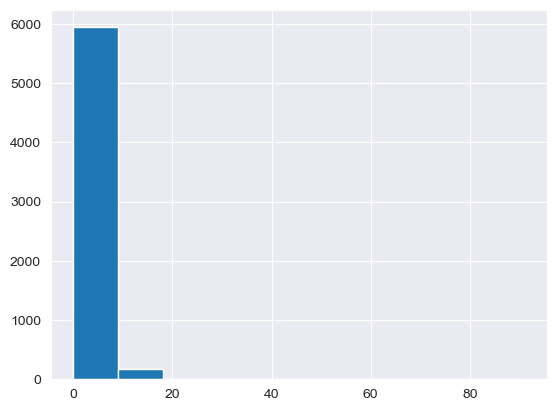

In [11]:
zinc = foods.loc[foods.nutrient_description == "Zinc, Zn"]

plt.hist(zinc.value);

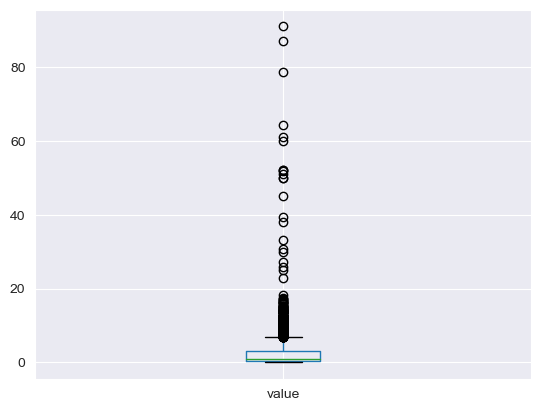

In [12]:
pd.plotting.boxplot(zinc, "value");

<AxesSubplot:xlabel='value', ylabel='Density'>

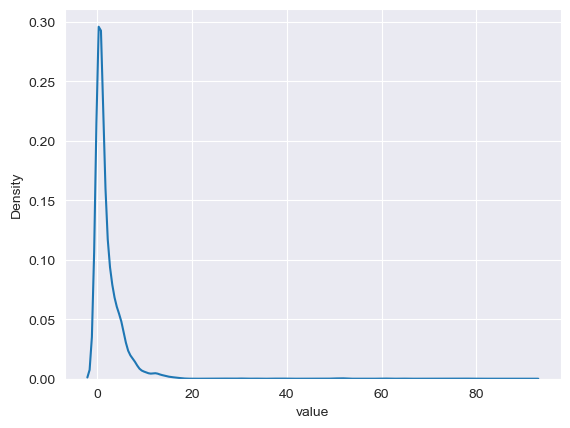

In [13]:
sns.kdeplot(data=zinc, x = "value")


In [14]:
zinc.value.describe()

count    6137.000000
mean        2.228589
std         3.975321
min         0.000000
25%         0.340000
50%         0.980000
75%         2.980000
max        90.950000
Name: value, dtype: float64

In [15]:
mean_zn = np.mean(foods.loc[foods.nutrient_description == "Zinc, Zn", "value"])

# Vergleiche ob Zn Value für Edamer über dem Mittelwert liegt.
foods.loc[(foods.food_description == "Cheese, edam") & (
    foods.nutrient_description == "Zinc, Zn")].value >= mean_zn

151    True
Name: value, dtype: bool

In [16]:
percentile = zinc.value.quantile(0.75)

foods.loc[(foods.food_description == "Cheese, edam") & (
    foods.nutrient_description == "Zinc, Zn")].value >= percentile

151    True
Name: value, dtype: bool

In [17]:
max_idx = zinc.value.idxmax()

zinc.loc[max_idx, :]

value                                               90.95
units                                                  mg
nutrient_description                             Zinc, Zn
nutrient_group                                   Elements
id                                                  15170
food_description        Mollusks, oyster, eastern, canned
manufacturer                                             
food_group                 Finfish and Shellfish Products
Name: 333726, dtype: object

In [1]:
%load_ext version_information

In [2]:
%version_information numpy, pandas, matplotlib, seaborn

Software versions
Python 3.10.4 64bit [MSC v.1916 64 bit (AMD64)]
IPython 8.4.0
OS Windows 10 10.0.19044 SP0
numpy 1.22.3
pandas 1.4.3
matplotlib 3.5.2
seaborn 0.11.2
Sun Oct 30 14:58:26 2022 Mitteleuropäische Zeit